# Import, Init

In [783]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [784]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

>>> train-test inited:  {'y_test_cut': True, 'X_test_cut': True, 'y_train_cut': True, 'X_train_cut': True}


In [785]:
# nn_manager_cut.X_train = nn_manager_cut.X_train[['Open', 'Vol']]
# nn_manager_cut.X_test = nn_manager_cut.X_test[['Open', 'Vol']]

In [786]:
# nn_manager_cut.X_train.drop[columns=['Open', ]]

## Normalizing

In [787]:
from sklearn.preprocessing import RobustScaler

nn_manager_cut.normalize_X(scaler=RobustScaler)

nn_manager_cut.X_train_normalized[:2]

array([[ 4.52988659e+00,  4.78975360e+00,  4.74139303e+00,
         1.74639067e+02,  1.29200649e+00,  1.87564906e+00,
         1.23854073e-01,  3.30862295e+00, -4.16368286e-01,
        -4.19170152e+02,  2.96856492e+00,  1.36703957e+00],
       [ 3.81150200e+00,  4.42010246e+00,  4.03002493e+00,
         1.86548731e+02,  1.24667529e+00,  1.87347194e+00,
         1.72651774e+00,  2.53817428e+00, -2.38363171e-01,
        -3.08142681e+01,  3.56691540e+00,  1.54784809e+00]])

# Model 

## Unrolling data to sequences

In [788]:
nn_manager_cut.unroll_X_to_sequences(sequence_len=4)

In [789]:
nn_manager_cut.X_test_unrolled[0]

array([[ 3.53689240e+01,  3.51928763e+01,  3.72144714e+01,
         6.43691996e-01,  8.78219500e-01,  3.22867247e+00,
         4.83528350e-01, -2.62732657e-02, -3.42710997e-01,
        -1.29561296e-01,  2.21669940e+00,  6.36455909e-01],
       [ 3.66991727e+01,  3.66113686e+01,  3.65890404e+01,
         7.00706344e-01,  1.06493891e+00,  3.22761248e+00,
        -2.85041974e-01,  1.70764865e-01, -3.42710997e-01,
        -1.29561296e-01,  2.21669940e+00,  6.36455909e-01],
       [ 3.90631428e+01,  3.79461332e+01,  3.74674023e+01,
         1.03303665e+00,  1.34978675e+00,  3.22633882e+00,
        -8.60041445e-02,  5.25127690e-01, -3.41687980e-01,
        -8.42312423e-01,  1.90828686e+00,  8.10769348e-01],
       [ 3.74178590e+01,  3.81480361e+01,  3.90945838e+01,
         7.63548826e-01,  1.35460228e+00,  3.22495080e+00,
         6.05842104e-02,  7.35483801e-01, -3.57033248e-01,
         7.15703157e-01,  3.41691933e+00,  9.04069166e-01]])

In [790]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[1]

array([[ 3.66991727e+01,  3.66113686e+01,  3.65890404e+01,
         7.00706344e-01,  1.06493891e+00,  3.22761248e+00,
        -2.85041974e-01,  1.70764865e-01, -3.42710997e-01,
        -1.29561296e-01,  2.21669940e+00,  6.36455909e-01],
       [ 3.90631428e+01,  3.79461332e+01,  3.74674023e+01,
         1.03303665e+00,  1.34978675e+00,  3.22633882e+00,
        -8.60041445e-02,  5.25127690e-01, -3.41687980e-01,
        -8.42312423e-01,  1.90828686e+00,  8.10769348e-01],
       [ 3.74178590e+01,  3.81480361e+01,  3.90945838e+01,
         7.63548826e-01,  1.35460228e+00,  3.22495080e+00,
         6.05842104e-02,  7.35483801e-01, -3.57033248e-01,
         7.15703157e-01,  3.41691933e+00,  9.04069166e-01],
       [ 3.65447733e+01,  3.69161259e+01,  3.78081799e+01,
         6.42551709e-01,  1.35107044e+00,  3.22358723e+00,
         7.93558608e-03,  7.70429879e-01, -3.59079284e-01,
         3.31283313e-01,  6.84514963e+00,  8.84127896e-01]])

## Model Assembling

In [791]:
nn_manager_cut.X_train.shape[1]

12

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

In [792]:
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal

n_steps_subseq = 2
n_seq = 2
n_features = nn_manager_cut.X_train.shape[1]

shape_cnn_lstm_train = dict(
            n_rows=nn_manager_cut.X_train_unrolled.shape[0], 
            n_seq=n_seq, 
            n_steps_subseq=n_steps_subseq, 
            n_features=n_features)

shape_cnn_lstm_test = {key:(value if key != 'n_rows' else nn_manager_cut.X_test_unrolled.shape[0]) 
                       for (key, value) in shape_cnn_lstm_train.items()}

shape_cnn_stacked = dict(
            n_rows=nn_manager_cut.X_train_unrolled.shape[0], 
            n_seq=4, 
            n_features=n_features) # not splitting to subseq

(shape_cnn_lstm_train, shape_cnn_lstm_test)

({'n_rows': 3178, 'n_seq': 2, 'n_steps_subseq': 2, 'n_features': 12},
 {'n_rows': 791, 'n_seq': 2, 'n_steps_subseq': 2, 'n_features': 12})

#### CNN-LSTM

In [793]:
# CNN-LSTM Architecture

weights_init = GlorotNormal()

conv1D_0 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same', kernel_initializer=weights_init)
conv1D_1 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')
# conv1D_2 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal')
# conv1D_3 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal')

# src: 
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=A%20convolutional%20neural
template_CNN_LSTM = [
    TimeDistributed(conv1D_0, input_shape=(None, shape_cnn_lstm_train['n_steps_subseq'], shape_cnn_lstm_train['n_features'])),
    TimeDistributed(conv1D_1),
#     TimeDistributed(conv1D_2),
#     TimeDistributed(conv1D_3),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(50, activation='relu', return_sequences = True),
    LSTM(50, activation='relu'),
    Dense(50),
    Dense(20),
    Dense(1)
]

#### Stacked LSTM

In [794]:
# Stacked LSTM

template_Stacked_LSTM = [
    LSTM(50, activation='relu' , input_shape=(n_steps_subseq, n_features)),
    Dense(1)
]

### Compiling Model with the chosen Architecture

In [795]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=5e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

training_params = dict(optimizer=opt_adam, loss='mean_absolute_error', metrics=['mae'])


nn_manager_cut.model_combine(template=template_CNN_LSTM, compile_dict=training_params)

>>> model compiled
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_243 (TimeDi (None, None, 2, 64)       832       
_________________________________________________________________
time_distributed_244 (TimeDi (None, None, 2, 64)       4160      
_________________________________________________________________
time_distributed_245 (TimeDi (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_246 (TimeDi (None, None, 64)          0         
_________________________________________________________________
lstm_101 (LSTM)              (None, None, 50)          23000     
_________________________________________________________________
lstm_102 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_178 (Dense)            (None

True

## Model Training

In [796]:
# CNN-LSTMs DataShapes
data_shape_cnn_lstm_train = (
    shape_cnn_lstm_train['n_rows'], 
    shape_cnn_lstm_train['n_seq'], 
    shape_cnn_lstm_train['n_steps_subseq'],
    shape_cnn_lstm_train['n_features']
)
data_shape_cnn_lstm_test = (
    shape_cnn_lstm_test['n_rows'], 
    shape_cnn_lstm_test['n_seq'], 
    shape_cnn_lstm_test['n_steps_subseq'],
    shape_cnn_lstm_test['n_features']
)

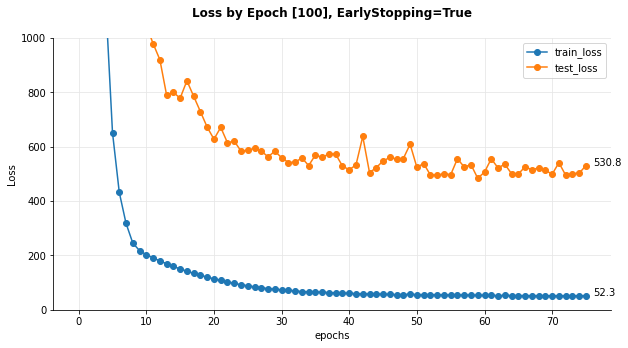

In [797]:
# %%time
nn_manager_cut.model_fit(n_epoch=100,
                           data_shape_train=data_shape_cnn_lstm_train,
                           data_shape_test=data_shape_cnn_lstm_test,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        )
plt.ylim(0,1e3);

In [798]:
# nn_manager_cut.model.predict(nn_manager_cut.X_test_unrolled[1].reshape)

# Model Tunning

## Base Model with changed time frames
one of the possible reasons for the poor loss is that 

# Playground

In [799]:
# sh = nn_manager_cut.X_test_unrolled[1].shape

# X_pred = nn_manager_cut.X_test_unrolled[1].reshape(int(sh[0]/n_steps_subseq), n_steps_subseq, n_features)

